# GraphRAG for Research Paper Understanding with Unstructured and Neo4j

Author: [Ajay Krishnan](https://linkedin.com/in/ajaykrish)

Understanding research papers can be challenging. You're not just reading isolated facts but navigating a network of interconnected ideas, methodologies, results, and citations that all build upon each other.

A typical Retrieval-Augmented Generation (RAG) setup works like this: take your question, fetch relevant text chunks from the paper, and pass them to an LLM to generate an answer.

This is a solid starting point, but it comes with some important limitations.

When you treat a paper as a collection of independent chunks, you miss the relationships between concepts. How does the proposed method relate to the baseline? What datasets were used to evaluate which models? What metrics measure what performance? These connections are crucial for truly understanding a paper.

For simple questions, vanilla RAG might be enough. But for research papers where understanding relationships between entities is crucial, this approach starts to break down.

In this notebook, we'll explore a smarter approach: **GraphRAG**. Instead of treating the paper as independent text chunks, we'll build a knowledge graph that explicitly captures entities and their relationships.

The GraphRAG system we'll build will be able to:
- **Extract key entities** from the research paper (models, datasets, metrics, techniques, tasks)
- **Identify relationships** between these entities (trained_on, evaluated_on, achieves, uses)
- **Build a queryable knowledge graph** that preserves the paper's conceptual structure
- **Answer complex questions** by traversing relationships and combining graph context with vector search

This gives our system a much richer understanding of the paper's structure, making it better equipped to handle questions that require connecting ideas across different sections.

To build this system, we'll use **Unstructured** for document processing and entity extraction, and **Neo4j** as our graph database.

Unstructured handles the complex task of parsing PDFs, extracting tables and figures, and using LLMs to identify entities and relationships. Neo4j stores these as a connected graph that we can query efficiently.

Let's dive in!

In [ ]:
!pip install -U "unstructured-client"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.8/207.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 12.2 MB/s eta 0:00:00


In [ ]:
import os
import time
from google.colab import userdata
from unstructured_client import UnstructuredClient


def pretty_print_model(response_model):
    print(response_model.model_dump_json(indent=4))

Before we can start processing documents, we need to authenticate with Unstructured's API.

If you haven't already, sign up for a free [Unstructured account](https://unstructured.io/?modal=try-for-free). Once you're signed in, you can navigate to the API Keys section in the platform to generate your API key.


In [ ]:
os.environ["UNSTRUCTURED_API_KEY"] = userdata.get("UNSTRUCTURED_API_KEY")
client = UnstructuredClient(api_key_auth=os.environ["UNSTRUCTURED_API_KEY"])

## Setting up the S3 Source Connector

Now that we have our Unstructured client ready, we need to tell it where to find our research paper.

Source connectors in Unstructured define where your documents live. In this example, we're using Amazon S3 to store the research paper PDF, but Unstructured supports [many other sources](https://docs.unstructured.io/api-reference/workflow/sources/overview) like Google Drive, Azure Blob Storage, and more.

**What you'll need:**

- `AWS_ACCESS`: Your AWS access key ID
- `AWS_SECRET`: Your AWS secret access key  
- `S3_REMOTE_URL`: The S3 URI to your bucket or folder, formatted as `s3://your-bucket-name/` or `s3://your-bucket-name/folder-path/`

Store these in your Colab secrets, and we'll use them to create a source connector that points to the research paper:

In [ ]:
os.environ["AWS_ACCESS"] = userdata.get("AWS_ACCESS")
os.environ["AWS_SECRET"] = userdata.get("AWS_SECRET")
os.environ["S3_REMOTE_URL"] = userdata.get("S3_REMOTE_URL")

In [ ]:
from unstructured_client.models.operations import CreateSourceRequest
from unstructured_client.models.shared import CreateSourceConnector

source_connector_response = client.sources.create_source(
    request=CreateSourceRequest(
        create_source_connector=CreateSourceConnector(
            name="GraphRag S3 Source Connector",
            type="s3",
            config={

                # For AWS access key ID with AWS secret access key authentication:
                "key": os.environ["AWS_ACCESS"],
                "secret": os.environ["AWS_SECRET"],

                "remote_url": os.environ["S3_REMOTE_URL"],
                "recursive": True
            }
        )
    )
)



/usr/local/lib/python3.12/dist-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  function=lambda v, h: h(v),
/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  return self.__pydantic_serializer__.to_python(


In [ ]:
pretty_print_model(source_connector_response.source_connector_information)

{
    "config": {
        "anonymous": false,
        "recursive": true,
        "remote_url": "s3://ajay-uns-devrel-content/graph-rag/",
        "key": "**********",
        "secret": "**********"
    },
    "created_at": "2025-10-07T20:14:07.340135Z",
    "id": "4289027c-d7c1-4ffb-987b-6ead19b75eca",
    "name": "GraphRag S3 Source Connector",
    "type": "s3",
    "updated_at": "2025-10-07T20:14:07.565559Z"
}


/usr/local/lib/python3.12/dist-packages/unstructured_client/models/shared/sourceconnectorinformation.py:184: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='s3', input_type=str])
  serialized = handler(self)


## Setting up the Neo4j Destination Connector

Now we need to configure where our processed data will go. We're using **Neo4j** as our destination because it's a graph database, which is perfect for storing entities and their relationships as a queryable knowledge graph.

For this notebook, we're using **Neo4j Aura**, which is Neo4j's fully managed cloud service. It's free to get started and handles all the infrastructure for you.

**Setting up Neo4j Aura:**

If you haven't already, you'll need to create a Neo4j Aura instance and a database. The setup process is straightforward and covered in detail in this [video tutorial](https://www.youtube.com/watch?v=fo8uDIm1zCE).

You can also check out the [Unstructured Neo4j destination documentation](https://docs.unstructured.io/api-reference/workflow/destinations/neo4j) for additional configuration options.

**What you'll need:**

- `NEO4J_CONNECTION_URI`: Your Neo4j Aura connection URI (format: `neo4j+s://xxxxx.databases.neo4j.io`)
- `NEO4J_USERNAME`: Your database username (typically `neo4j`)
- `NEO4J_PASSWORD`: Your database password
- `NEO4J_DATABASE_NAME`: The name of your database (typically `neo4j`)

Store these in your Colab secrets, and we'll create a destination connector:

In [ ]:
os.environ["NEO4J_USERNAME"] = userdata.get("NEO4J_USERNAME")
os.environ["NEO4J_PASSWORD"] = userdata.get("NEO4J_PASSWORD")
os.environ["NEO4J_DATABASE_NAME"] = userdata.get("NEO4J_DATABASE_NAME")
os.environ["NEO4J_CONNECTION_URI"] = userdata.get("NEO4J_CONNECTION_URI")


In [ ]:
from unstructured_client.models.operations import CreateDestinationRequest
from unstructured_client.models.shared import CreateDestinationConnector


destination_connector_response = client.destinations.create_destination(
    request=CreateDestinationRequest(
        create_destination_connector=CreateDestinationConnector(
            name="GraphRag Destination Connector",
            type="neo4j",
            config={
                "uri": os.environ["NEO4J_CONNECTION_URI"],
                "database": os.environ["NEO4J_DATABASE_NAME"],
                "username": os.environ["NEO4J_USERNAME"],
                "password": os.environ["NEO4J_PASSWORD"],
                "batch_size": 20
            }
        )
    )
)



/usr/local/lib/python3.12/dist-packages/pydantic/functional_validators.py:218: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='neo4j', input_type=str])
  function=lambda v, h: h(v),
/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='neo4j', input_type=str])
  return self.__pydantic_serializer__.to_python(


In [ ]:
pretty_print_model(destination_connector_response.destination_connector_information)

{
    "config": {
        "batch_size": 20,
        "database": "neo4j",
        "password": "**********",
        "uri": "neo4j+s://32e7a678.databases.neo4j.io",
        "username": "neo4j"
    },
    "created_at": "2025-10-07T20:14:08.842139Z",
    "id": "21cb3907-af23-4554-9c1a-3d782465247b",
    "name": "GraphRag Destination Connector",
    "type": "neo4j",
    "updated_at": "2025-10-07T20:14:08.912690Z"
}


/usr/local/lib/python3.12/dist-packages/unstructured_client/models/shared/destinationconnectorinformation.py:190: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `enum` - serialized value may not be as expected [input_value='neo4j', input_type=str])
  serialized = handler(self)


## Creating the Document Processing Workflow

Now that we have our source (S3) and destination (Neo4j) configured, we need to define **how** the document should be processed. This is where Unstructured's workflow system shines.

A workflow is a pipeline of processing nodes, where each node performs a specific transformation on the document. The data flows through these nodes sequentially, with each step building on the previous one.

Here's the pipeline we'll build for our research paper:

**1. Partitioner** (`hi_res` strategy)
   - Extracts structured content from the PDF
   - Identifies text, images, and tables
   - Uses Object Detection Models and OCR for better accuracy with complex academic layouts

**2. Image Summarizer** (OpenAI vision model)
   - Generates descriptions for figures and diagrams
   - Captures visual context that's important for understanding the paper

**3. Table Summarizer** (Anthropic Claude)
   - Creates summaries of experimental results tables
   - Extracts key metrics and findings

**4. Named Entity Recognition (NER)** (OpenAI with custom prompt)
   - **This is the ♥ of our GraphRAG system**
   - Extracts entities like models, datasets, metrics, techniques
   - Identifies relationships between entities (trained_on, evaluated_on, achieves, etc.)
   - We'll dive deeper into this in a moment

**5. Chunker** (`chunk_by_title`)
   - Organizes content into semantically meaningful chunks
   - Optimized for structured papers with clear sections
   - Smaller chunks (max 1000 chars) work better for graph construction

**6. Embedder** (OpenAI text-embedding-3-large)
   - Generates vector embeddings for semantic search
   - These embeddings will let us find relevant chunks using similarity

Let's define these nodes:

In [ ]:
from unstructured_client.models.shared import (
    WorkflowNode,
    WorkflowType,
    Schedule
)

partition_node = WorkflowNode(
    name="Partitioner",
    subtype="unstructured_api",
    type="partition",
    settings={
        "strategy": "hi_res",
        "extract_image_block_types": ["Image", "Table"],
    }
)

image_summarizer_node = WorkflowNode(
    name="Image summarizer",
    subtype="openai_image_description",
    type="prompter",
    settings={}
)

table_summarizer_node = WorkflowNode(
    name="Table summarizer",
    subtype="anthropic_table_description",
    type="prompter",
    settings={}
)

ner_node = WorkflowNode(
    name="Enrichment",
    subtype="openai_ner",
    type="prompter",
    settings={
        "prompt_interface_overrides": {
            "prompt": {
                "user": """Extract ONLY the following entity types from research papers:

- MODEL: Named machine learning models (e.g., GPT-2, BERT, ResNet) — not generic “model” references or techniques.
- DATASET: Proper dataset names (e.g., WebText, ImageNet, COCO) — exclude generic “training data”.
- METRIC: Evaluation metrics (e.g., BLEU, accuracy, F1, perplexity).
- TECHNIQUE: Distinct methods or approaches (e.g., fine-tuning, zero-shot learning, reinforcement learning).
- TASK: AI tasks (e.g., image classification, language modeling, summarization).
- ARCHITECTURE_COMPONENT: Components of model architectures (e.g., encoder, decoder, attention).

DO NOT extract:
- Years or dates (2017, 2020, etc.)
- Author names or citations (e.g., “Smith et al.”)
- Paper titles
- Generic or vague terms (“architecture”, “training”, “dataset”, “model”)
Extract only the most **meaningful and unambiguous** relationships between these entities.

Use the following simplified relationship set:

- MODEL → DATASET: **trained_on**, **evaluated_on**
- MODEL → METRIC: **achieves**, **evaluated_by**
- MODEL → TECHNIQUE: **uses**
- MODEL → TASK: **performs**
- TASK → DATASET: **evaluated_with**
- MODEL → ARCHITECTURE_COMPONENT: **has_component**

Guidelines:
- Do **not** infer relationships unless the connection is explicit in the text.
- Prefer precision over recall; it’s fine to skip uncertain links.
- Avoid duplicate or symmetric relationships (one direction only).
- Ignore any entities that don’t connect to at least one other entity.

[START OF TEXT]
{{text}}
[END OF TEXT]

Return a JSON object with this schema:
{
  "items": [
    { "entity": "Entity name", "type": "Entity type" }
  ],
  "relationships": [
    { "from": "Entity name", "relationship": "Relationship type", "to": "Entity name" }
  ]
}
"""
            }
        }
    }
)

chunk_node = WorkflowNode(
    name="Chunker",
    subtype="chunk_by_title",
    type="chunk",
    settings={
        "new_after_n_chars": 200,
        "max_characters": 1000,
        "overlap": 50,
        "combine_text_under_n_chars": 200,
        "multipage_sections": True,
        "include_orig_elements": True,
    }
)

embedder_node = WorkflowNode(
    name='Embedder',
    subtype='azure_openai',
    type="embed",
    settings={
        'model_name': 'text-embedding-3-large'
    }
)



response = client.workflows.create_workflow(
    request={
        "create_workflow": {
            "name": f"GraphRAG Workflow",
            "source_id": source_connector_response.source_connector_information.id,
            "destination_id": destination_connector_response.destination_connector_information.id,
            "workflow_type": WorkflowType.CUSTOM,
            "workflow_nodes": [
                partition_node,
                image_summarizer_node,
                table_summarizer_node,
                ner_node,
                chunk_node,
                embedder_node,

            ],
        }
    }
)

workflow_id = response.workflow_information.id
pretty_print_model(response.workflow_information)

{
    "created_at": "2025-10-07T20:17:02.503851Z",
    "destinations": [
        "21cb3907-af23-4554-9c1a-3d782465247b"
    ],
    "id": "e38b4d86-6a4f-4700-9f6e-7b3a3aec7c9f",
    "name": "GraphRAG Workflow",
    "sources": [
        "4289027c-d7c1-4ffb-987b-6ead19b75eca"
    ],
    "status": "active",
    "workflow_nodes": [
        {
            "name": "Chunker",
            "subtype": "chunk_by_title",
            "type": "chunk",
            "id": "61dcd30f-3c7c-45a6-a203-9deff73280a8",
            "settings": {
                "unstructured_api_url": null,
                "unstructured_api_key": null,
                "multipage_sections": true,
                "combine_text_under_n_chars": 200,
                "include_orig_elements": true,
                "new_after_n_chars": 200,
                "max_characters": 1000,
                "overlap": 50,
                "overlap_all": false,
                "contextual_chunking_strategy": null
            }
        },
        {
   

The NER (Named Entity Recognition) node is where the magic happens for GraphRAG through Unstructured. This is what transforms our paper from text into a structured knowledge graph.

**Why these entity types?**

Research papers, especially in machine learning, naturally organize around a few key concepts:
- **Models**: The architectures and systems being proposed or compared (BERT, Transformer)
- **Datasets**: The data used for training and evaluation (ImageNet, SQuAD)
- **Metrics**: How performance is measured (accuracy, perplexity)
- **Techniques**: Methods and approaches (fine-tuning, zero-shot learning)
- **Tasks**: What the models are trying to accomplish (translation, image classification)
- **Architecture Components**: Building blocks of models (encoder, decoder)

These entities form the "nodes" of our knowledge graph. A well-structured paper naturally describes how these elements relate to each other, and that's what makes it perfect for graph representation.

**Why these specific relationships?**

The relationships we extract capture the fundamental connections in machine learning research:
- `MODEL → DATASET` (trained_on, evaluated_on): What data was used for training and testing
- `MODEL → METRIC` (achieves, evaluated_by): What performance was measured
- `MODEL → TECHNIQUE` (uses): What methods the model employs
- `MODEL → TASK` (performs): What the model is designed to do
- `MODEL → ARCHITECTURE_COMPONENT` (has_component): How the model is structured

These relationships let us answer questions like:
- "What datasets was GPT-2 evaluated on?"
- "What models achieve the best BLEU scores?"
- "What techniques does the Transformer use?"

**Design choices: Precision over Recall**

Notice our prompt explicitly says to **prefer precision over recall**. We'd rather miss some entities than extract noisy, ambiguous ones. Why?

1. **Generic terms are unhelpful**: Extracting "model" or "dataset" as entities doesn't give us useful nodes
2. **Dates and authors aren't structural**: While important, they don't help us understand the technical relationships
3. **Graph quality > Graph size**: A small, accurate graph is more useful than a large, noisy one

**The JSON Schema Requirement**

The specific format is required on Unstructured's end 🙂:
```json
{
  "items": [
    { "entity": "Entity name", "type": "Entity type" }
  ],
  "relationships": [
    { "from": "Entity name", "relationship": "Relationship type", "to": "Entity name" }
  ]
}

## Running the workflow

Now that we've defined how we want to process our documentation, let's start the workflow and wait for it to complete:

In [ ]:
res = client.workflows.run_workflow(
    request={
        "workflow_id": workflow_id,
    }
)

pretty_print_model(res.job_information)

{
    "created_at": "2025-10-07T20:17:04.419033Z",
    "id": "62e96172-53a2-4ca6-a978-d185dd89333f",
    "status": "SCHEDULED",
    "workflow_id": "e38b4d86-6a4f-4700-9f6e-7b3a3aec7c9f",
    "workflow_name": "GraphRAG Workflow",
    "job_type": "ephemeral"
}


In [ ]:
response = client.jobs.list_jobs(
    request={
        "workflow_id": workflow_id
    }
)

last_job = response.response_list_jobs[0]
job_id = last_job.id
print(f"job_id: {job_id}")

job_id: 62e96172-53a2-4ca6-a978-d185dd89333f


Now that we've created and started a job, we can poll Unstructured's `get_job` endpoint and check for its status every 30s till completion

In [ ]:
import time

def poll_job_status(job_id, wait_time=30):
    while True:
        response = client.jobs.get_job(
            request={
                "job_id": job_id
            }
        )

        job = response.job_information

        if job.status == "SCHEDULED":
            print(f"Job is scheduled, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        elif job.status == "IN_PROGRESS":
            print(f"Job is in progress, polling again in {wait_time} seconds...")
            time.sleep(wait_time)
        else:
            print("Job is completed")
            break

    return job

job = poll_job_status(job_id)
pretty_print_model(job)

Job is scheduled, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is in progress, polling again in 30 seconds...
Job is completed
{
    "created_at": "2025-10-07T20:17:04.419033",
    "id": "62e96172-53a2-4ca6-a978-d185dd89333f",
    "status": "COMPLETED",
    "workflow_id": "e38b4d86-6a4f-4700-9f6e-7b3a3aec7c9f",
    "workflow_name": "GraphRAG Workflow",
    "job_type": "ephemeral",
    "runtime": "PT0S"
}


At this point, we've completed all the foundational steps:

- Extracted structured elements from the research paper using a **Partitioner**
- Generated descriptions for images and tables using vision and language models
- **Extracted entities and relationships** to build our knowledge graph structure
- Organized the content into chunks with a **Chunker**
- Generated vector embeddings for semantic search with an **Embedder**

Our processed data is now stored in Neo4j as a connected knowledge graph, with entities as nodes, relationships as edges, and text chunks linked to the entities they contain.

Next, we'll build the GraphRAG retrieval system that can leverage this graph structure to answer complex questions about the research paper.

## GraphRAG: Querying the Knowledge Graph

Now comes the exciting part: using our knowledge graph to answer questions about the research paper.

Unlike vanilla RAG, which only uses vector similarity to find relevant chunks, our GraphRAG system will:

1. **Start with vector search** to find relevant text chunks
2. **Traverse the knowledge graph** to find entities mentioned in those chunks
3. **Explore relationships** between entities to gather additional context
4. **Combine graph structure with text content** to generate informed answers

This approach lets us answer questions that require understanding how concepts relate to each other, not just finding where they're mentioned.

Let's set up our connections and build the retrieval functions:

In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.8/325.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from neo4j import GraphDatabase
import numpy as np
from openai import OpenAI
import json

# Initialize clients
neo4j_driver = GraphDatabase.driver(
    userdata.get('NEO4J_CONNECTION_URI'),
    auth=(userdata.get('NEO4J_USERNAME'), userdata.get('NEO4J_PASSWORD'))
)

openai_client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

### Building the GraphRAG Retrieval and Generation Pipeline

Now we'll implement the core functions that power our GraphRAG system. These three functions work together to retrieve context from the knowledge graph and generate answers:

**1. `retrieve_with_graph_rag(driver, openai_client, question, top_k=3)`**

This is where the magic happens. The function performs a multi-step retrieval process:

- **Step 1: Vector Search** - Find the top-k most similar chunks to the question using cosine similarity on embeddings
- **Step 2: Entity Discovery** - For each retrieved chunk, traverse the graph to find entities mentioned in that chunk
- **Step 3: Relationship Extraction** - Get relationships between these entities (trained_on, evaluated_on, achieves, etc.)
- **Step 4: Context Expansion** (optional) - Follow relationships to related entities and fetch their associated chunks for additional context

The Cypher query follows the graph structure: `Chunk ← Element ← Entity → Related Entity`

This approach gives us both the relevant text chunks AND the structured knowledge about how entities relate to each other.

**2. `generate_answer(openai_client, question, retrieval_results)`**

Takes the rich context retrieved from the graph and constructs a prompt that includes:
- The original text chunks
- Knowledge graph relationships in a readable format
- List of key entities mentioned

This graph-enhanced context helps the LLM understand not just what's mentioned, but how concepts connect to each other.

**3. `display_answer(question, answer, entities, relationships)`**

A utility function to format and display the answer along with the entities and relationships that were used. This makes it easy to see what knowledge from the graph contributed to the answer.

Let's implement these functions:

In [ ]:
def retrieve_with_graph_rag(driver, openai_client, question, top_k=3):
    """
    Graph RAG using the correct path: Chunk <- Element <- Entity
    """
    response = openai_client.embeddings.create(
        model="text-embedding-3-large",
        input=question
    )
    query_embedding = response.data[0].embedding

    with driver.session() as session:
        vector_query = """
        // Step 1: Vector search on chunks
        MATCH (chunk:Chunk)
        WHERE chunk.embeddings IS NOT NULL
        WITH chunk, gds.similarity.cosine(chunk.embeddings, $query_embedding) as similarity
        ORDER BY similarity DESC
        LIMIT $top_k

        // Step 2: Get elements that are part of this chunk
        MATCH (element:UnstructuredElement)-[:PART_OF_CHUNK]->(chunk)

        // Step 3: Get entities from those elements
        MATCH (element)-[:HAS_ENTITY]->(entity:Entity)

        // Step 4: Get relationships between these entities
        OPTIONAL MATCH (entity)-[r]->(related:Entity)
        WHERE type(r) IN $rel_types

        WITH chunk, similarity,
             collect(DISTINCT entity.id) as entities,
             collect(DISTINCT {from: entity.id, rel: type(r), to: related.id}) as rels

        RETURN
            chunk.text as text,
            similarity,
            entities,
            rels as relationships
        ORDER BY similarity DESC
        """

        results = list(session.run(
            vector_query,
            query_embedding=query_embedding,
            top_k=top_k,
            rel_types=['trained_on', 'evaluated_on', 'achieves',
                      'evaluated_by', 'uses', 'performs',
                      'has_component', 'evaluated_with']
        ))

        all_texts = []
        all_entities = set()
        all_relationships = []

        for record in results:
            all_texts.append(record["text"])
            all_entities.update(record["entities"])

            for rel in record["relationships"]:
                if rel and rel.get('from') and rel.get('to') and rel.get('rel'):
                    all_relationships.append({
                        'from': rel['from'],
                        'relationship': rel['rel'],
                        'to': rel['to']
                    })

        unique_rels = []
        seen = set()
        for rel in all_relationships:
            key = (rel['from'], rel['relationship'], rel['to'])
            if key not in seen:
                seen.add(key)
                unique_rels.append(rel)

        # Get additional context from related entities
        if unique_rels:
            expanded_entity_ids = [rel['to'] for rel in unique_rels[:20]]

            expand_query = """
            MATCH (entity:Entity)<-[:HAS_ENTITY]-(element:UnstructuredElement)
            WHERE entity.id IN $entity_ids

            MATCH (element)-[:PART_OF_CHUNK]->(chunk:Chunk)

            RETURN DISTINCT chunk.text as text
            LIMIT 3
            """

            expand_results = list(session.run(
                expand_query,
                entity_ids=expanded_entity_ids
            ))

            for record in expand_results:
                all_texts.append(record["text"])

        print(f"✅ {len(all_texts)} chunks, {len(all_entities)} entities, {len(unique_rels)} relationships")

    return {
        "context": "\n\n".join(all_texts[:8]),
        "entities": sorted(list(all_entities)),
        "relationships": unique_rels[:20]
    }

In [ ]:
def generate_answer(openai_client, question, retrieval_results):
    """
    Generate answer using LLM with graph-enhanced context
    """
    context = retrieval_results["context"]
    entities = retrieval_results["entities"]
    relationships = retrieval_results["relationships"]

    # Build relationship context string
    rel_context = ""
    if relationships:
        rel_context = "\n\nKnowledge Graph Relationships:\n"
        for rel in relationships[:15]:  # Limit to top 15 to avoid token overflow
            rel_context += f"- {rel['from']} --[{rel['relationship']}]--> {rel['to']}\n"

    # Build the prompt
    prompt = f"""You are an AI research assistant helping someone understand a research paper.

Question: {question}

Context from Paper:
{context}
{rel_context}

Key Entities Mentioned: {', '.join(entities[:20])}

Based on the retrieved context and knowledge graph relationships above, provide a clear, comprehensive answer to the question. Use the entities and relationships to provide structured insights about the paper.

Answer:"""

    # Generate response
    response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful AI research assistant specializing in explaining academic papers clearly and comprehensively."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=600
    )

    return response.choices[0].message.content

In [ ]:
def display_answer(question, answer, entities, relationships):
    """
    Display formatted answer with entities and graph relationships
    """
    print("=" * 80)
    print(f"Question: {question}")
    print("=" * 80)
    print("Answer:")
    print(answer)

    if entities:
        print("Key Entities Referenced:")
        for entity in entities[:15]:  # Show top 15 entities
            print(f"  • {entity}")
        if len(entities) > 15:
            print(f"  ... and {len(entities) - 15} more")
        print()

    if relationships:
        print("Graph Relationships Used:")
        seen = set()
        count = 0
        for rel in relationships:
            rel_str = f"{rel['from']} --[{rel['relationship']}]--> {rel['to']}"
            if rel_str not in seen:
                print(f"  • {rel_str}")
                seen.add(rel_str)
                count += 1
                if count >= 12:  # Limit display to 12 relationships
                    break
        if len(relationships) > 12:
            print(f"  ... and {len(relationships) - 12} more")
        print()
    else:
        print("Graph Relationships: None found")
        print()

    print("=" * 80)
    print()

Now let's analyze the **GPT-2 paper** - the work that established the decoder-only transformer blueprint used by virtually all modern LLMs today.

In [ ]:
test_question = "What is GPT-2 and how does it work?"

results = retrieve_with_graph_rag(neo4j_driver, openai_client, test_question, top_k=3)

print("\n" + "="*80)
answer = generate_answer(openai_client, test_question, results)
display_answer(test_question, answer, results['entities'], results['relationships'])

✅ 6 chunks, 9 entities, 38 relationships

Question: What is GPT-2 and how does it work?
Answer:
GPT-2 is a large-scale language model developed by OpenAI, and it is primarily trained using a dataset known as WebText. The model is designed to perform a variety of natural language processing tasks, including language modeling, reading comprehension, translation, and question answering. 

Here are some key insights into how GPT-2 works and its performance based on the paper's context:

1. **Model Architecture and Training**: GPT-2 is built upon the transformer architecture, which is known for its effectiveness in capturing long-range dependencies in text. The model is trained on a large corpus of text (WebText) to predict the next word in a sentence, which helps it learn patterns and structures of language.

2. **Language Modeling**: GPT-2 excels at language modeling tasks, where it generates coherent and contextually relevant text by predicting subsequent words given an initial input. Th

Here's what this looks like in our knowledge graph:

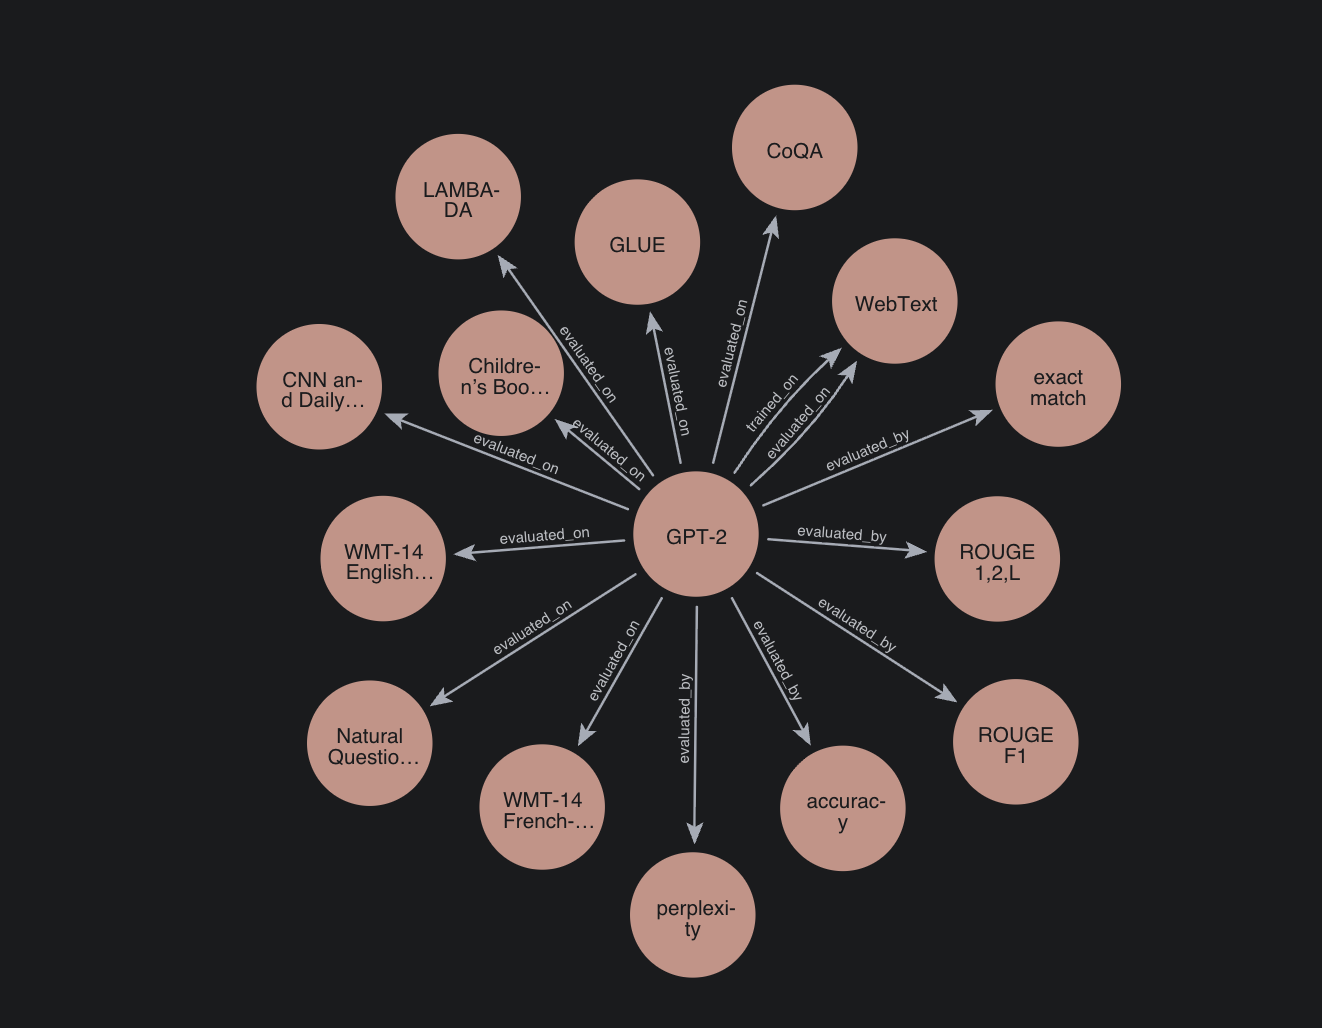

This visualization shows exactly what makes GraphRAG powerful, we're not just finding text that mentions GPT-2, we're understanding the structured relationships between the model, the datasets it was evaluated on, and the tasks it performs.

Let's ask a more conceptual question about the paper's contribution:

In [ ]:
question_2 = "What problem does this paper solve?"

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_2, top_k=3)
answer = generate_answer(openai_client, question_2, retrieval_results)
display_answer(question_2, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 5 chunks, 4 entities, 2 relationships
Question: What problem does this paper solve?
Answer:
The paper addresses the problem of performing downstream tasks without relying on supervised training data, which is often required for traditional machine learning approaches. Specifically, it aims to solve the challenge of applying language models to a wide range of tasks in a zero-shot setting, meaning the models can handle tasks without any prior specific training or modification of parameters and architecture.

The key contribution of this paper is demonstrating that language models, particularly those using self-attention architectures like the Transformer, can perform zero-shot learning effectively. This is achieved by leveraging the natural capacity of language models to understand and predict sequences of natural language, which allows them to perform tasks such as commonsense reasoning and sentiment analysis without additional supervised data.

By connecting two lines of work—supervi

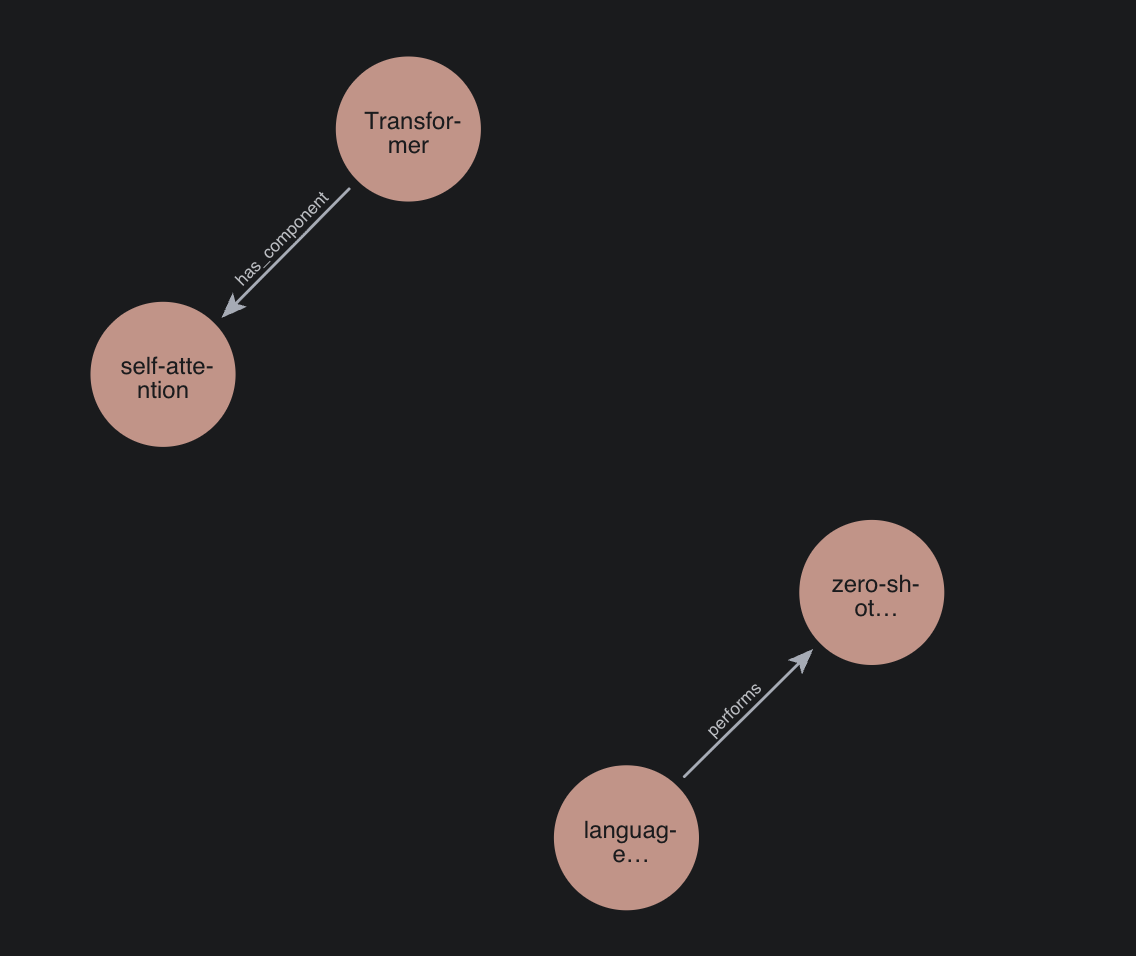

Now let's dive deeper into the technical architecture:


In [ ]:
question_3 = "What is GPT-2 and how does it work? Explain the architecture."

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_3, top_k=5)
answer = generate_answer(openai_client, question_3, retrieval_results)
display_answer(question_3, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 8 chunks, 14 entities, 39 relationships
Question: What is GPT-2 and how does it work? Explain the architecture.
Answer:
GPT-2, developed by OpenAI, is a large-scale language model that builds on the architecture of its predecessor, GPT (Generative Pre-trained Transformer). It is designed to perform a variety of natural language processing tasks such as language modeling, translation, reading comprehension, and question answering, among others. Here's a breakdown of how GPT-2 works and its architecture:

### Architecture

1. **Transformer Architecture**: 
   - GPT-2 uses a transformer architecture, specifically a decoder-only version, which is a type of neural network architecture introduced by Vaswani et al. in 2017. Transformers utilize self-attention mechanisms to process and generate sequences of text, allowing them to capture long-range dependencies and relationships in data more effectively than previous recurrent models.

2. **Size and Capacity**:
   - GPT-2 is notable for its 

Let's explore the training methodology:


In [ ]:
question_4 = "What datasets and training setup were used for GPT-2?"

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_4, top_k=4)
answer = generate_answer(openai_client, question_4, retrieval_results)
display_answer(question_4, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 7 chunks, 11 entities, 41 relationships
Question: What datasets and training setup were used for GPT-2?
Answer:
GPT-2 was trained on a dataset named WebText. WebText is a large and diverse collection of text scraped from the internet, consisting of millions of webpages. The intent behind using such a dataset was to gather a wide variety of natural language demonstrations across different domains and contexts, which is crucial for enabling the model to perform various tasks without explicit supervision (zero-shot task transfer).

The training setup involved creating four language models (LMs) of varying sizes, with GPT-2 being the largest model at 1.5 billion parameters. The model sizes were chosen to be approximately log-uniformly spaced. The learning rate for each model was manually tuned to achieve the best perplexity on a 5% held-out sample of the WebText dataset.

WebText was used for both training and evaluation of GPT-2. However, the model was also evaluated on several other da

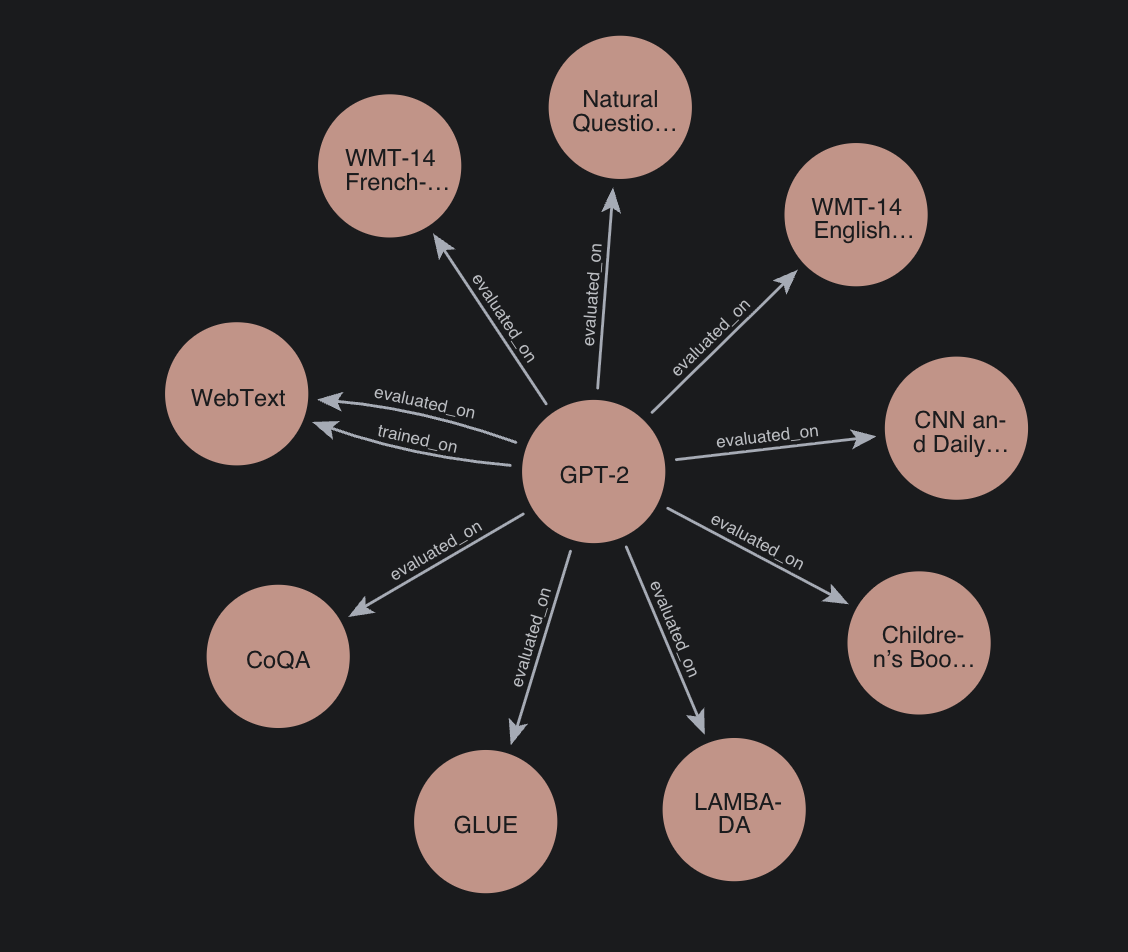

How did the model actually perform? Let's examine the results:


In [ ]:
question_5 = "What were the main results and how well did GPT-2 perform?"

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_5, top_k=4)
answer = generate_answer(openai_client, question_5, retrieval_results)
display_answer(question_5, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 7 chunks, 15 entities, 42 relationships
Question: What were the main results and how well did GPT-2 perform?
Answer:
The main results of the paper indicate that GPT-2, when evaluated across various natural language processing (NLP) tasks in a zero-shot setting, exhibits varying levels of performance. Here are the key findings:

1. **Reading Comprehension**: GPT-2 performs competitively with supervised baselines in a zero-shot setting on reading comprehension tasks. This suggests that GPT-2 can understand and process text to a reasonable degree even without task-specific training.

2. **Summarization**: On summarization tasks, GPT-2 is able to perform the task qualitatively but only achieves rudimentary performance when measured by quantitative metrics like ROUGE F1 scores. This indicates that while GPT-2 can generate summaries, its quality lags behind more advanced models specifically trained for summarization.

3. **Question Answering**: On the Natural Questions dataset, GPT-2 corre

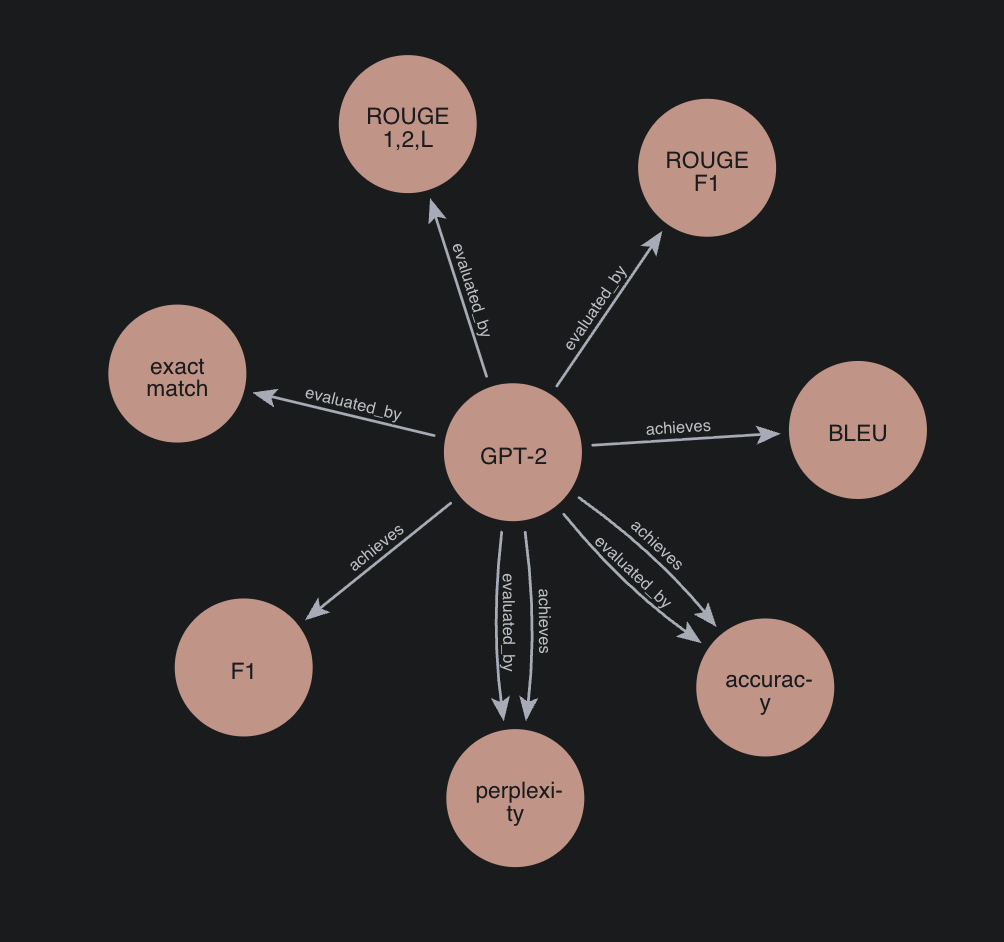

Finally, let's ask about the broader implications:


In [ ]:
question_6 = "What are the key takeaways and implications of this research?"

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_6, top_k=3)
answer = generate_answer(openai_client, question_6, retrieval_results)
display_answer(question_6, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 6 chunks, 8 entities, 42 relationships
Question: What are the key takeaways and implications of this research?
Answer:
The research paper discusses the performance of the GPT-2 language model, particularly focusing on its ability to perform various natural language processing (NLP) tasks in a zero-shot setting. Here are the key takeaways and implications of the research:

1. **Unsupervised Task Learning**: The paper suggests that unsupervised task learning is a promising area for further research. The findings indicate that pre-training techniques can enable models like GPT-2 to learn and perform tasks directly without needing additional supervised adaptation or modification. This could help explain why pre-trained language models have been so successful across various downstream NLP tasks.

2. **Zero-Shot Performance**: GPT-2 demonstrates impressive zero-shot capabilities, achieving state-of-the-art performance on 7 out of 8 tested language modeling datasets. This means that GPT-2 c

As a bonus, let's explore what makes GPT-2 unique compared to prior work:


In [ ]:
question_7 = "What techniques and innovations make GPT-2 different from previous language models?"

retrieval_results = retrieve_with_graph_rag(neo4j_driver, openai_client, question_7, top_k=5)
answer = generate_answer(openai_client, question_7, retrieval_results)
display_answer(question_7, answer, retrieval_results['entities'], retrieval_results['relationships'])

✅ 8 chunks, 20 entities, 44 relationships
Question: What techniques and innovations make GPT-2 different from previous language models?
Answer:
GPT-2 introduces several techniques and innovations that distinguish it from previous language models, including its predecessor, GPT. Here are some of the key differences and advancements:

1. **Scale and Capacity**: GPT-2 significantly increases the scale of the model, having 1.5 billion parameters, which is over an order of magnitude more than the original GPT. This increase in capacity is crucial for its performance, particularly in zero-shot task transfer, as performance improves in a log-linear fashion with model size.

2. **Training Data**: GPT-2 is trained on a newly curated dataset called WebText, which consists of millions of webpages. This dataset is vast and diverse, allowing the model to learn a wide range of language tasks without explicit supervision.

3. **Zero-Shot Learning**: Unlike many previous models that require task-speci

## Conclusion

In this notebook, we built a complete GraphRAG system that transforms how we interact with research papers. Instead of treating papers as bags of text chunks, we created a structured knowledge graph that captures the relationships between models, datasets, metrics, techniques, and tasks.

### What We Built

1. **Automated Knowledge Extraction** - Used Unstructured's workflow system to process PDFs, extract entities and relationships using LLMs, and build a knowledge graph in Neo4j automatically

2. **Structured Knowledge Graph** - Created a queryable graph where we can see explicit connections:
   - `GPT-2 --[trained_on]--> WebText`
   - `GPT-2 --[evaluated_on]--> CoQA, GLUE, LAMBADA...`
   - `GPT-2 --[achieves]--> BLEU, F1, accuracy`
   - `Transformer --[has_component]--> self-attention`

3. **Intelligent Graph-Enhanced Retrieval** - Combined vector search with graph traversal to find not just relevant text, but also the relationships between concepts

4. **Accurate, Grounded Answers** - Generated factually correct answers using both text content and graph structure

### What Makes GraphRAG Different

Looking at our question-answering examples, we can see how the graph approach enables different capabilities:

**Structured Knowledge Extraction**  
Instead of just retrieving text mentioning "GPT-2", we extracted structured entities (models, datasets, metrics) and their relationships, enabling answers that require understanding connections.

**Graph Traversal and Context Expansion**  
When we asked "What datasets were used?", the system:
- Found relevant chunks via vector search
- Identified entities in those chunks (GPT-2, WebText, etc.)
- Retrieved their direct relationships (`GPT-2 --[evaluated_on]--> datasets`)
- Expanded context by fetching chunks associated with related entities

**Adaptive Query Paths**  
Different questions surface different graph patterns:
- Conceptual questions → architectural relationships (`Transformer --[has_component]--> self-attention`)
- Training questions → data relationships (`GPT-2 --[trained_on]--> WebText`)
- Performance questions → metric relationships (`GPT-2 --[achieves]--> BLEU`)

This graph-structured approach is particularly well-suited for research papers, where understanding the relationships between models, datasets, techniques, and results is crucial for comprehension.

---

## Ready to Build Your Own GraphRAG System?

Whether you're working with research papers, technical documentation, or any domain with structured relationships, you can build a similar system for your use case.

**Sign up for a [free Unstructured account](https://unstructured.io/?modal=try-for-free)**, connect your document sources, and start building knowledge graphs from your PDFs.

With Unstructured's workflow system and graph database integrations, you can go from raw research papers to a production-ready GraphRAG system in an afternoon - complete with entity extraction, relationship mapping, and intelligent retrieval.

Stop treating your documents as unstructured text. Start uncovering the knowledge graphs hidden inside them.